In [1]:
import imblearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("median_scaled.csv")

In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [5]:
from sklearn.metrics import confusion_matrix
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Bankrupted','Not Bankrupted']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))

In [6]:
from sklearn.metrics import average_precision_score, precision_recall_curve
def plot_aucprc(classifier, scores):
    precision, recall, _ = precision_recall_curve(y_test, scores, pos_label=0)
    average_precision = average_precision_score(y_test, scores)

    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))

    plt.plot(recall, precision, label='area = %0.3f' % average_precision, color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="best")
    plt.show()

In [16]:
data_X = data.iloc[:, :-1]
data_y = data["class"]
data_X["Attr70"] = data_X["Attr70"].astype("category")

In [28]:
xgb_X = data.iloc[:, :-1]
xgb_y = data["class"]

## Decision Tree

In [17]:
model = DecisionTreeClassifier()

In [18]:
re_stf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 2)
scores = cross_val_score(model, data_X, data_y, scoring = "f1_micro", cv = re_stf)

In [19]:
print("Mean CV F1 : %.3f"% np.mean(scores))

Mean CV F1 : 0.936


In [20]:
scores = cross_val_score(model, data_X, data_y, scoring = "roc_auc", cv = re_stf)

In [21]:
print("Mean CV ROC_AUC : %.3f"% np.mean(scores))

Mean CV ROC_AUC : 0.707


## Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
forest = RandomForestClassifier(n_estimators=500, random_state=24)

In [24]:
scores = cross_val_score(forest, data_X, data_y, scoring = "f1_micro", cv = re_stf)
print("Mean CV F1 : %.3f"% np.mean(scores))
scores = cross_val_score(forest, data_X, data_y, scoring = "roc_auc", cv = re_stf)
print("Mean CV ROC_AUC : %.3f"% np.mean(scores))

Mean CV F1 : 0.958
Mean CV ROC_AUC : 0.898


## XGBoost

In [25]:
from xgboost import XGBClassifier

In [131]:
xgb_model = XGBClassifier(learning_rate = 0.2, n_estimators  = 500)

In [132]:
scores = cross_val_score(xgb_model, xgb_X, xgb_y, scoring = "f1_micro", cv = re_stf)
print("Mean CV F1 : %.3f"% np.mean(scores))
scores = cross_val_score(xgb_model, xgb_X, xgb_y, scoring = "roc_auc", cv = re_stf)
print("Mean CV ROC_AUC : %.3f"% np.mean(scores))

Mean CV F1 : 0.967
Mean CV ROC_AUC : 0.930


In [136]:
xgb_model.fit(xgb_X, xgb_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [137]:
xgb_model.feature_importances_

array([0.01886187, 0.01723204, 0.01888179, 0.01473847, 0.02684857,
       0.02971356, 0.01870607, 0.01315519, 0.01149079, 0.04747294,
       0.01383566, 0.01931978, 0.02034402, 0.02037761, 0.03253245,
       0.04623654, 0.02145286, 0.01665938, 0.01348233, 0.01760193,
       0.02772082, 0.01576179, 0.03044714, 0.0123904 , 0.021648  ,
       0.03235957, 0.01793846, 0.01794969, 0.01429102, 0.01128194,
       0.03356811, 0.01660088, 0.02447979, 0.02128282, 0.02944262,
       0.01331144, 0.00830462, 0.01289476, 0.0892937 , 0.11008856],
      dtype=float32)

In [138]:
from xgboost import plot_importance

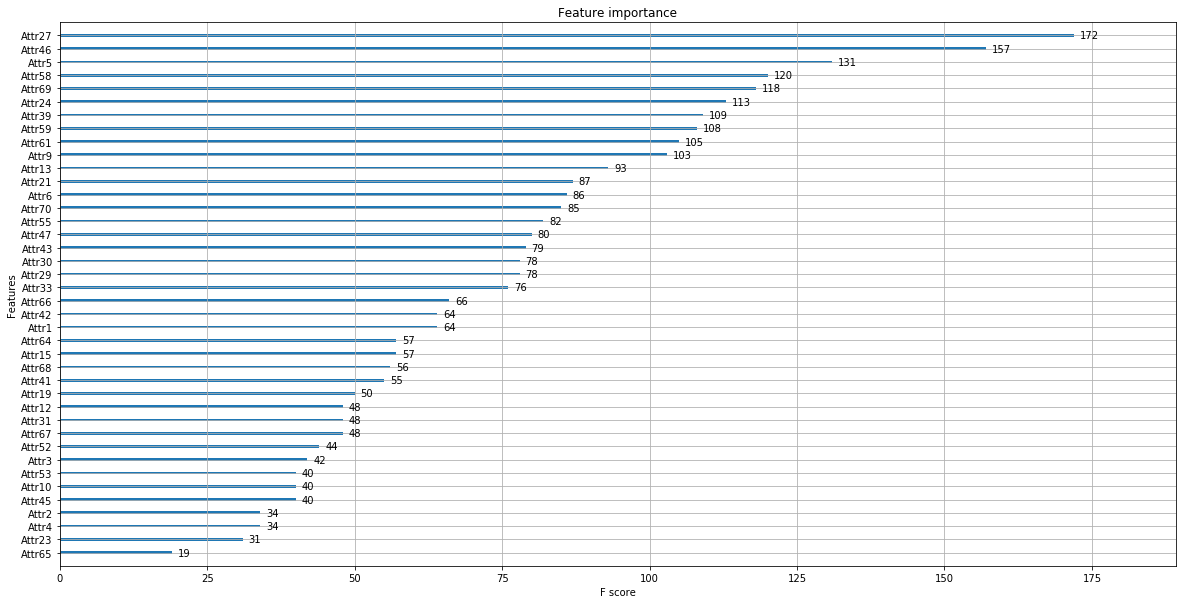

In [143]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_importance(xgb_model, ax=ax)

<BarContainer object of 40 artists>

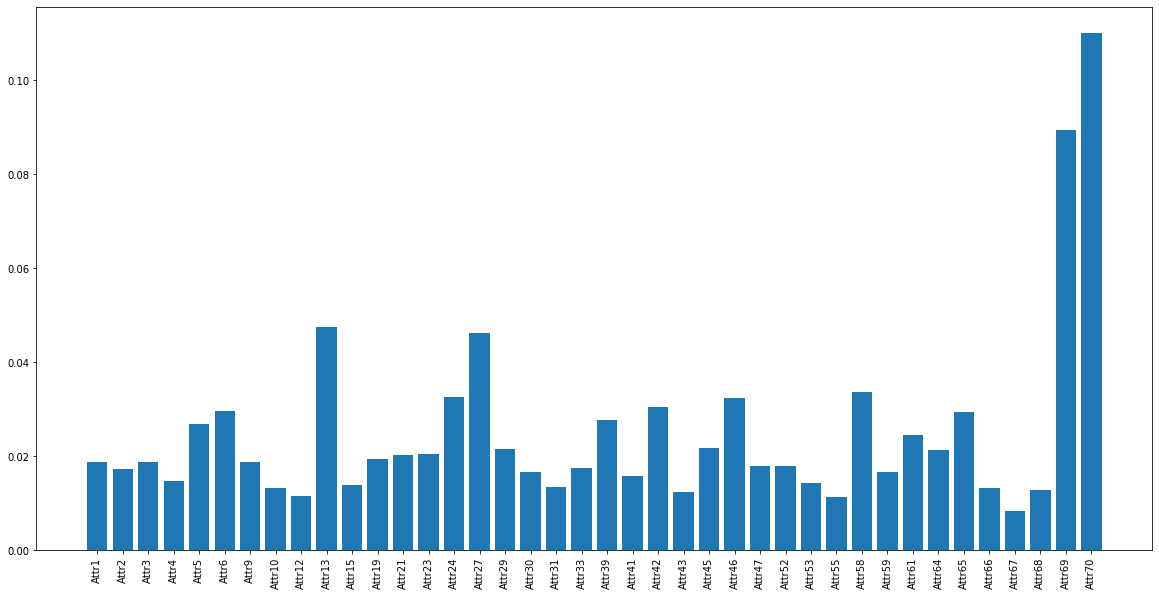

In [150]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 'vertical')
plt.bar(xgb_X.columns, xgb_model.feature_importances_)

## SMOTE

## Decision Tree

In [119]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [114]:
def smote_random_class(data, model) :
    
    bank = data[data["class"] == 1]
    not_bank = data[data["class"] == 0]
    
    idx = list(bank.index)
    idx_len = round(len(idx)/5)
    
    first = list(np.random.choice(idx, idx_len, replace = False))
    idx2 = [x for x in idx if x not in first]
    second = list(np.random.choice(idx2, idx_len, replace = False))
    idx3 = [x for x in idx2 if x not in second]
    third = list(np.random.choice(idx3, idx_len, replace = False))
    idx4 = [x for x in idx3 if x not in third]
    fourth = list(np.random.choice(list(idx4), idx_len, replace =False))
    fifth = [x for x in idx4 if x not in fourth]
    
    not_idx = list(not_bank.index)
    not_idx_len = round(len(not_idx)/5)
    
    not_first = list(np.random.choice(not_idx, not_idx_len, replace = False))
    not_idx2 = [x for x in not_idx if x not in not_first]
    not_second = list(np.random.choice(not_idx2, not_idx_len, replace = False))
    not_idx3 = [x for x in not_idx2 if x not in not_second]
    not_third = list(np.random.choice(not_idx3, not_idx_len, replace = False))
    not_idx4 = [x for x in not_idx3 if x not in not_third]
    not_fourth = list(np.random.choice(list(not_idx4), not_idx_len, replace =False))
    not_fifth = [x for x in not_idx4 if x not in not_fourth]
    
    lst = [first, second, third, fourth, fifth]
    not_lst = [not_first, not_second, not_third, not_fourth, not_fifth]
    
    for i in range(len(lst)):
        lst[i].extend(not_lst[i])
        
    f1_scores = []
    roc_scores = []

    for i in range(5):
        print("------------ ",i+1, " ------------\n")
        test_X = xgb_X.iloc[lst[i]]
        test_y = xgb_y.iloc[lst[i]]
        train_X = xgb_X.drop(lst[i])
        train_y = xgb_y.drop(lst[i])
        X_resampled, y_resampled = SMOTE().fit_sample(train_X, train_y)
        
        model.fit(X_resampled, y_resampled)
        pred_y = model.predict(test_X)
        f = f1_score(test_y, pred_y, average = 'micro')
        r = roc_auc_score(test_y, pred_y)
        
        f1_scores.append(f)
        roc_scores.append(r)
        
        print("f1 - ", f, ", roc - ", r)
        
    print("F1 : ", np.mean(f1_scores))
    print("ROC AUC : ", np.mean(roc_scores))

In [115]:
smote_random_class(data, DecisionTreeClassifier())

------------  1  ------------

f1 -  0.8745414526779164 , roc -  0.6190291763490834
------------  2  ------------

f1 -  0.8606016140865739 , roc -  0.6444562785093382
------------  3  ------------

f1 -  0.8672046955245781 , roc -  0.713513426284534
------------  4  ------------

f1 -  0.8796771826852531 , roc -  0.6348545485842155
------------  5  ------------

f1 -  0.8814055636896047 , roc -  0.6853129072243589
F1 :  0.8726861017327853
ROC AUC :  0.659433267390306


## Random Forest

In [117]:
smote_random_class(data, RandomForestClassifier(n_estimators=500))

------------  1  ------------

f1 -  0.9391049156272927 , roc -  0.6990113176693347
------------  2  ------------

f1 -  0.9471753484959647 , roc -  0.6639286943798951
------------  3  ------------

f1 -  0.942039618488628 , roc -  0.7202319476719167
------------  4  ------------

f1 -  0.9369038884812912 , roc -  0.6322779499096308
------------  5  ------------

f1 -  0.9348462664714495 , roc -  0.6747661274089142
F1 :  0.9400140075129253
ROC AUC :  0.6780432074079382


## XGB

In [30]:
xgb_model = XGBClassifier(learning_rate = 0.2, n_estimators  = 600)

In [31]:
scores = cross_val_score(xgb_model, xgb_X, xgb_y, scoring = "f1_micro", cv = re_stf)
print("Mean CV F1 : %.3f"% np.mean(scores))
scores = cross_val_score(xgb_model, xgb_X, xgb_y, scoring = "roc_auc", cv = re_stf)
print("Mean CV ROC_AUC : %.3f"% np.mean(scores))

Mean CV F1 : 0.967
Mean CV ROC_AUC : 0.930


In [118]:
smote_random_class(data, XGBClassifier(learning_rate = 0.2, n_estimators  = 600))

------------  1  ------------

f1 -  0.9486426999266324 , roc -  0.7302747654703503
------------  2  ------------

f1 -  0.942039618488628 , roc -  0.7464605387726998
------------  3  ------------

f1 -  0.9471753484959647 , roc -  0.8147430932093983
------------  4  ------------

f1 -  0.9603815113719736 , roc -  0.854500172131853
------------  5  ------------

f1 -  0.9509516837481699 , roc -  0.8060632065177086
F1 :  0.9498381724062737
ROC AUC :  0.790408355220402


## SMOTE + Undersampling

In [121]:
def smote_under_random_class(data, model, k) :
    
    bank = data[data["class"] == 1]
    not_bank = data[data["class"] == 0]
    
    idx = list(bank.index)
    idx_len = round(len(idx)/5)
    
    first = list(np.random.choice(idx, idx_len, replace = False))
    idx2 = [x for x in idx if x not in first]
    second = list(np.random.choice(idx2, idx_len, replace = False))
    idx3 = [x for x in idx2 if x not in second]
    third = list(np.random.choice(idx3, idx_len, replace = False))
    idx4 = [x for x in idx3 if x not in third]
    fourth = list(np.random.choice(list(idx4), idx_len, replace =False))
    fifth = [x for x in idx4 if x not in fourth]
    
    not_idx = list(not_bank.index)
    not_idx_len = round(len(not_idx)/5)
    
    not_first = list(np.random.choice(not_idx, not_idx_len, replace = False))
    not_idx2 = [x for x in not_idx if x not in not_first]
    not_second = list(np.random.choice(not_idx2, not_idx_len, replace = False))
    not_idx3 = [x for x in not_idx2 if x not in not_second]
    not_third = list(np.random.choice(not_idx3, not_idx_len, replace = False))
    not_idx4 = [x for x in not_idx3 if x not in not_third]
    not_fourth = list(np.random.choice(list(not_idx4), not_idx_len, replace =False))
    not_fifth = [x for x in not_idx4 if x not in not_fourth]
    
    lst = [first, second, third, fourth, fifth]
    not_lst = [not_first, not_second, not_third, not_fourth, not_fifth]
    
    for i in range(len(lst)):
        lst[i].extend(not_lst[i])
        
    f1_scores = []
    roc_scores = []

    for i in range(5):
        print("------------ ",i+1, " ------------\n")
        test_X = xgb_X.iloc[lst[i]]
        test_y = xgb_y.iloc[lst[i]]
        train_X = xgb_X.drop(lst[i])
        train_y = xgb_y.drop(lst[i])
        X_resampled, y_resampled = SMOTE(sampling_strategy = 0.1, k_neighbors = k).fit_sample(train_X, train_y)
        X_sample, y_sample = RandomUnderSampler(sampling_strategy = 0.5).fit_sample(X_resampled, y_resampled)
        
        model.fit(X_sample, y_sample)
        pred_y = model.predict(test_X)
        f = f1_score(test_y, pred_y, average = 'micro')
        r = roc_auc_score(test_y, pred_y)
        
        f1_scores.append(f)
        roc_scores.append(r)
        
        print("f1 - ", f, ", roc - ", r)
        
    print("F1 : ", np.mean(f1_scores))
    print("ROC AUC : ", np.mean(roc_scores))

In [123]:
smote_under_random_class(data, DecisionTreeClassifier(), 1)

------------  1  ------------

f1 -  0.8136463683052091 , roc -  0.7114693605301662
------------  2  ------------

f1 -  0.8576669112252384 , roc -  0.7215928651346931
------------  3  ------------

f1 -  0.8341892883345561 , roc -  0.7354279628195197
------------  4  ------------

f1 -  0.8584005869405723 , roc -  0.7219801618039418
------------  5  ------------

f1 -  0.8565153733528551 , roc -  0.7174035110023413
F1 :  0.8440837056316862
ROC AUC :  0.7215747722581324


In [125]:
smote_under_random_class(data, RandomForestClassifier(n_estimators = 400), 1)

------------  1  ------------

f1 -  0.9075568598679383 , roc -  0.7413718908684053
------------  2  ------------

f1 -  0.9288334556126191 , roc -  0.7722749376022033
------------  3  ------------

f1 -  0.9244314013206163 , roc -  0.7896226009122987
------------  4  ------------

f1 -  0.9222303741746148 , roc -  0.7228892331525949
------------  5  ------------

f1 -  0.9128843338213762 , roc -  0.7536418438589243
F1 :  0.9191872849594329
ROC AUC :  0.7559601012788854


In [130]:
smote_under_random_class(data, XGBClassifier(n_estimators = 400, learning_rate = 0.15), k=1)

------------  1  ------------

f1 -  0.9361702127659575 , roc -  0.7958193476202772
------------  2  ------------

f1 -  0.9310344827586207 , roc -  0.845565453137103
------------  3  ------------

f1 -  0.9273661041819515 , roc -  0.8305146742404683
------------  4  ------------

f1 -  0.9347028613352898 , roc -  0.8081590498321714
------------  5  ------------

f1 -  0.9333821376281113 , roc -  0.8032450815243302
F1 :  0.9325311597339863
ROC AUC :  0.81666072127087


## DONE!